# Drone Tracking with Stone Soup

This notebook is looking at the [Kaggle Drone Identification and Tracking dataset](https://www.kaggle.com/c/icmcis-drone-tracking) using [Stone Soup](https://stonesoup.rtfd.io/).

This example focuses on the tracking element, with classification currently simply using the mode of associated detections from the tracking process.

In [17]:
!pip install git+https://github.com/dstl/Stone-Soup.git@e550d5cb5e6dd3086164e2ae4a2a1664eaf1867a#egg=stonesoup git+https://github.com/sdhiscocks/stonesoup-kaggle-drone-tracking.git@7e3b64135dff6c8c5fdfb559a5dd689d85f25acf#egg=stonesoup_kaggle_drone_tracking

  Using cached stonesoup-0.1b6.dev2+ge550d5c-py3-none-any.whl
  Using cached stonesoup_kaggle_drone_tracking-0.1.dev1+g7e3b641-py3-none-any.whl


## Create tracker
### Imports

In [18]:
import datetime
import os
from math import ceil
from io import StringIO

import pandas as pd
import numpy as np

from stonesoup.dataassociator.neighbour import GNNWith2DAssignment
from stonesoup.deleter.error import CovarianceBasedDeleter
from stonesoup.deleter.multi import CompositeDeleter
from stonesoup.deleter.time import UpdateTimeDeleter
from stonesoup.feeder.multi import MultiDataFeeder
from stonesoup.feeder.time import TimeBufferedFeeder
from stonesoup.hypothesiser.distance import DistanceHypothesiser
from stonesoup.initiator.simple import MultiMeasurementInitiator
from stonesoup.measures import Mahalanobis
from stonesoup.models.transition.linear import CombinedLinearGaussianTransitionModel, ConstantVelocity
from stonesoup.predictor.kalman import ExtendedKalmanPredictor
from stonesoup.tracker.simple import MultiTargetTracker
from stonesoup.types.array import StateVector, CovarianceMatrix
from stonesoup.types.state import GaussianState
from stonesoup.updater.kalman import ExtendedKalmanUpdater

# Custom components created for this dataset
from stonesoup.plugins.kaggle_drone.dejup_feeder import Uniqueificator
from stonesoup.plugins.kaggle_drone.initiator import AlviraAndArcusInitiator
from stonesoup.plugins.kaggle_drone.sensor_location_gater import SensorLocationGater
from stonesoup.plugins.kaggle_drone.reader import DroneGroundTruthReader, ALVIRAReader, ARCUSReader, DIANAReader, VENUSReader
from stonesoup.plugins.kaggle_drone.writer import write_output_csv, generate_timestamps, scenario_timestamps

### Create Readers

Create readers to read in the detections. These readers also create the measurement models which are linked to each detection, and such we also define noise parameters of expcted model uncertainty. Additional feeders are also used to handle duplicates and ensuring data is yeilded in time order.

These readers convert input detections to elevation, bearing and range (as appropriate) in a Cartesian coordinate space of east, north, up/altitude, relative to position of Diana sensor and 0 altitude (sea level). This is to better model the sensors' uncertainty.

In [19]:
scenario = "/kaggle/input/icmcis-drone-tracking/icmcis-drone-detection (2)/train/train/Scenario_1_1/"

arcus = ARCUSReader( # Elevation, bearing, range
    scenario,
    pos_noise_diag=[(np.pi/4)**2, np.radians(1)**2, 25**2], vel_noise_diag=[1, 1, 1],
    min_reflection=-25, max_reflection=-10,
)
alvira = ALVIRAReader( # Bearing, range
    scenario,
    pos_noise_diag=[np.radians(1)**2, 25**2], vel_noise_diag=[1, 1],
    min_reflection=-np.inf, max_reflection=35,
)
diana = DIANAReader( # Bearing, range
    scenario,
    pos_noise_diag=[np.radians(3)**2, 1000],
)
venus = VENUSReader( # Bearing
    scenario,
    pos_noise_diag=[np.radians(3)**2],
)

# Use this for plotting later.
sensor_positions = {
    'arcus': arcus.model.model_list[0].translation_offset[[0, 1], 0],
    'alvira': alvira.model.model_list[0].translation_offset[[0, 1], 0],
    'diana': diana.model.translation_offset[[0, 1], 0],
    'venus': venus.model.translation_offset[[0, 1], 0],
}

# Remove duplicates
arcus = Uniqueificator(arcus)
alriva = Uniqueificator(alvira)

# Buffer and sort; ensure input data in time order
arcus = TimeBufferedFeeder(arcus)
alvira = TimeBufferedFeeder(alvira)
diana = TimeBufferedFeeder(diana)
venus = TimeBufferedFeeder(venus)

# Combine into single stream of detections, in time order.
detector = MultiDataFeeder([alvira, arcus, diana, venus])

### Create Predictor and Updater

Create our model used for prediction, using 3 CV models, making state space $ x, \dot x, y, \dot y, z, \dot z $; where $x$ is east, $y$ is north, and $z$ is altitude.

In [20]:
transition_model = CombinedLinearGaussianTransitionModel([ConstantVelocity(0.6)]*3)
predictor = ExtendedKalmanPredictor(transition_model)

Create our updater. We won't define a model here, as we'll used the ones assigned to detections.

In [21]:
updater = ExtendedKalmanUpdater(measurement_model=None)

### Create Hypothesiser and Data Associator

This create hypothesier and data associator componets used for associating tracks and detections. Also create slightly stricter versions of these to limit track initiation.

In [22]:
hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=4)

# This is reducing missed distance to 2 units of Mahalanobis i.e. std. deviation, for initialisation
init_hypothesiser = DistanceHypothesiser(predictor, updater, measure=Mahalanobis(), missed_distance=2)

# This will ignore sensor data when drone within min. distance. Avoids bad bearing/elevation measurements
# causing issues in particular with rapid changes in velocity.
hypothesiser = SensorLocationGater(hypothesiser, min_distance_from_sensor=80)
init_hypothesiser = SensorLocationGater(init_hypothesiser, min_distance_from_sensor=80)

data_associator = GNNWith2DAssignment(hypothesiser)
init_data_associator = GNNWith2DAssignment(init_hypothesiser)

### Create Track Initiators and Deleters

The deleters in this example will remove tracks where no detections have been associated for a period of time,
or uncertainty in position has grown too large.

In [23]:
deleter = CompositeDeleter(
    [
        UpdateTimeDeleter(time_since_update=datetime.timedelta(seconds=30), delete_last_pred=True),
         CovarianceBasedDeleter(covar_trace_thresh=5000, mapping=[0, 2], delete_last_pred=True),
    ],
    intersect=False)

# More aggressive deletion when trying to initalise a track
init_deleter = CompositeDeleter(
    [
        UpdateTimeDeleter(time_since_update=datetime.timedelta(seconds=15), delete_last_pred=True),
         CovarianceBasedDeleter(covar_trace_thresh=3000, mapping=[0, 2], delete_last_pred=True),
    ],
    intersect=False)

Our initiator will use the detections position/velocity from the radar for easting/northing $x$/$y$ (hence just leaving prior state vector and covariance `0` for those elements), but use a  prior value for altitude where Alvria 2D Radar initialises the track.

In [24]:
prior = GaussianState([0, 0, 0, 0, 50, 0], np.diag([0, 0, 0, 0, 1000, 100]))

base_initiator = MultiMeasurementInitiator(
    prior_state=prior,
    measurement_model=None,
    deleter=init_deleter,
    data_associator=init_data_associator,
    updater=updater,
    min_points=6,
)

We only want to use radar sensors, and this also limits to where radar classifies target as DRONE/SUSPECTED_DRONE.

In [25]:
initiator = AlviraAndArcusInitiator(base_initiator)

## Run Tracker and Plot Results

In [26]:
tracker = MultiTargetTracker(
    detector=detector,
    initiator=initiator,
    deleter=deleter,
    data_associator=data_associator,
    updater=updater,
)

In [27]:
tracks = set()
detections = set()
for time, ctracks in tracker:
    tracks |= ctracks
    detections |= tracker.detector.detections
len(tracks)

2

Also read in ground truth data, if available.

In [28]:
ground_truth_reader = DroneGroundTruthReader(scenario, "2020")
ground_truth = set()
for time, truths in ground_truth_reader:
    ground_truth.update(truths)
    
gt_timestamps = {state.timestamp for truth in ground_truth for state in truth}

And plot tracks (in different colours) with their associated uncertainty, against ground truth if available, and sensor locations.

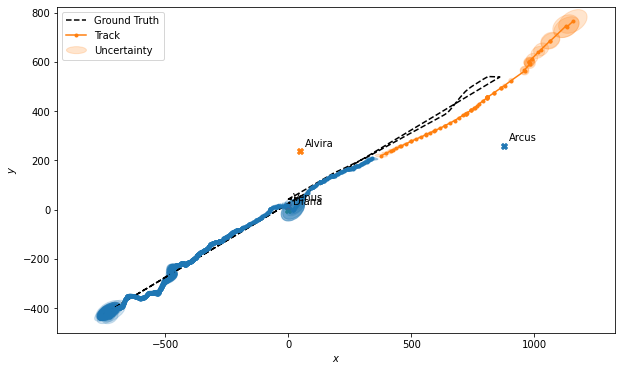

In [29]:
from stonesoup.plotter import Plotter

plotter = Plotter()
plotter.plot_ground_truths(ground_truth, [0, 2], color='black')
plotter.plot_tracks(tracks, [0,2], uncertainty=True)
for name, position in sensor_positions.items():
    plotter.ax.scatter(*position, label=name, marker='X')
    plotter.ax.text(*position+20, name.title())
track_xlim = plotter.ax.get_xlim()
track_ylim = plotter.ax.get_ylim()

And adding radar sensor detections to the plot. Note that these detections are ones filtered by the readers (min/max reflection parameters).

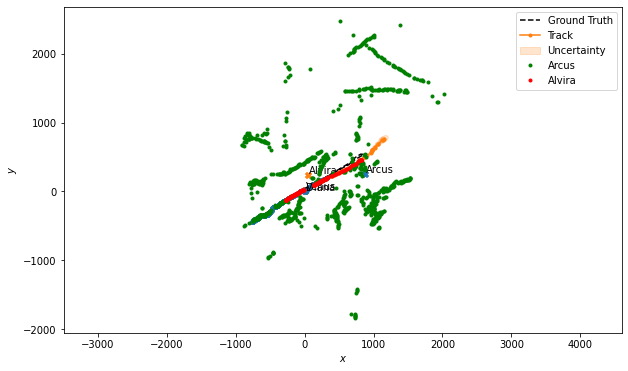

In [30]:
for sensor, color in {('Arcus', 'g'), ('Alvira', 'r')}:
    plotter.plot_measurements(
        {detection for detection in detections if detection.metadata['sensor'] == sensor}, [0, 2],
        measurements_label=sensor, color=color, marker='.', zorder=10)
plotter.fig

Chaning limits to around tracks again.

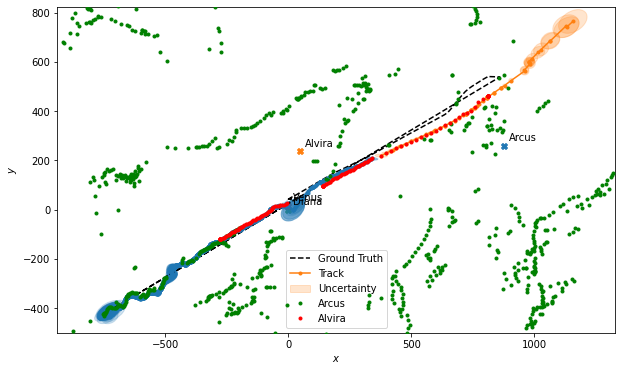

In [31]:
plotter.ax.set_xlim(track_xlim)
plotter.ax.set_ylim(track_ylim)
plotter.fig

## Generate Output File

The output file includes interpolating tracks to specified timestamps (based on ground truth in this example), with classification/identification simply using mode of associated detections from all sensors.

In [32]:
if not ground_truth: # Test
    timestamps = scenario_timestamps[os.path.basename(scenario)]
else: # Train
    timestamps = generate_timestamps(min(gt_timestamps).replace(microsecond=0), max(gt_timestamps))
output = StringIO() # use StringIO so we can use with Pandas to visualise, rather than write to disk
write_output_csv(output, tracks, timestamps, min_track_points=20)
output.seek(0)
pd.read_csv(output)

,TrackDateTimeUTC,TrackID,TrackPositionLatitude,TrackPositionLongitude,TrackPositionAltitude,TrackClassification,TrackIdentification,TrackSource
0,2020-09-29 12:14:21,80fe4e5c-2471-4ee8-8dab-b4d153938f00,51.521238,5.863833,50.017326,SUSPECTED_DRONE,aladrian-MAVIC PRO,Alvira
1,2020-09-29 12:14:22,80fe4e5c-2471-4ee8-8dab-b4d153938f00,51.521306,5.864058,50.018623,SUSPECTED_DRONE,aladrian-MAVIC PRO,Alvira
2,2020-09-29 12:14:23,80fe4e5c-2471-4ee8-8dab-b4d153938f00,51.521372,5.864282,50.019953,SUSPECTED_DRONE,aladrian-MAVIC PRO,Alvira
3,2020-09-29 12:14:24,80fe4e5c-2471-4ee8-8dab-b4d153938f00,51.521439,5.864505,50.021332,SUSPECTED_DRONE,aladrian-MAVIC PRO,NaN
4,2020-09-29 12:14:25,80fe4e5c-2471-4ee8-8dab-b4d153938f00,51.521503,5.864727,50.022739,SUSPECTED_DRONE,aladrian-MAVIC PRO,Alvira
...,...,...,...,...,...,...,...,...
361,2020-09-29 12:22:40,1363518a-b591-4ee2-aada-41d87a000f5d,51.515418,5.847457,107.859686,DRONE,aladrian-MAVIC PRO,NaN
362,2020-09-29 12:22:41,1363518a-b591-4ee2-aada-41d87a000f5d,51.515428,5.847469,107.784409,DRONE,aladrian-MAVIC PRO,NaN
363,2020-09-29 12:22:42,1363518a-b591-4ee2-aada-41d87a000f5d,51.515438,5.847481,107.709133,DRONE,aladrian-MAVIC PRO,NaN
364,2020-09-29 12:22:43,1363518a-b591-4ee2-aada-41d87a000f5d,51.515334,5.847595,107.495089,DRONE,aladrian-MAVIC PRO,Venus
